### Mode Evaluator Example 

In [ ]:
from models.regex import RegexModel
from data_loader import AnnotationDataLoader
from model_evaluation import ModelEvalWrapper, ModelEvaluator, ModelEvalWrapperInterface, ModelReport, ReportsComparison

# Load the regex model and the dataloader 
regex_m = RegexModel()
dataloader = AnnotationDataLoader()

regex_m.model_title = "Regex"
regex_m.model_info = "a"

# warp it model evaluator
## Evaluate model
# regex_m_wrapper = ModelEvalWrapper(regex_m, "Regex", "The baseline regex classifer")

In [ ]:
# regex_m_wrapper.predict(["asd", "asdadad"])

[2, 2]

In [2]:
import pandas as pd
t1 = dataloader.get_train()
t2 = dataloader.get_validation()
t3 = dataloader.get_test()

all = pd.concat([t1, t2, t3])

In [3]:
all

,protein_annotation,label
0,"Activator 1 36 kDa, putative",0
1,ARAD1C36740p,0
2,Abasic site processing protein YMR114C,2
3,Amino acid dehydrogenase,2
4,"Transcription regulator HTH, LysR",2
...,...,...
495,Anaerobic ribonucleoside-triphosphate reductas...,2
496,Beta-aspartyl asparaginyl family,2
497,Murein hydrolase activator NlpD,2
498,Outer membrane lipoprotein pcp,2



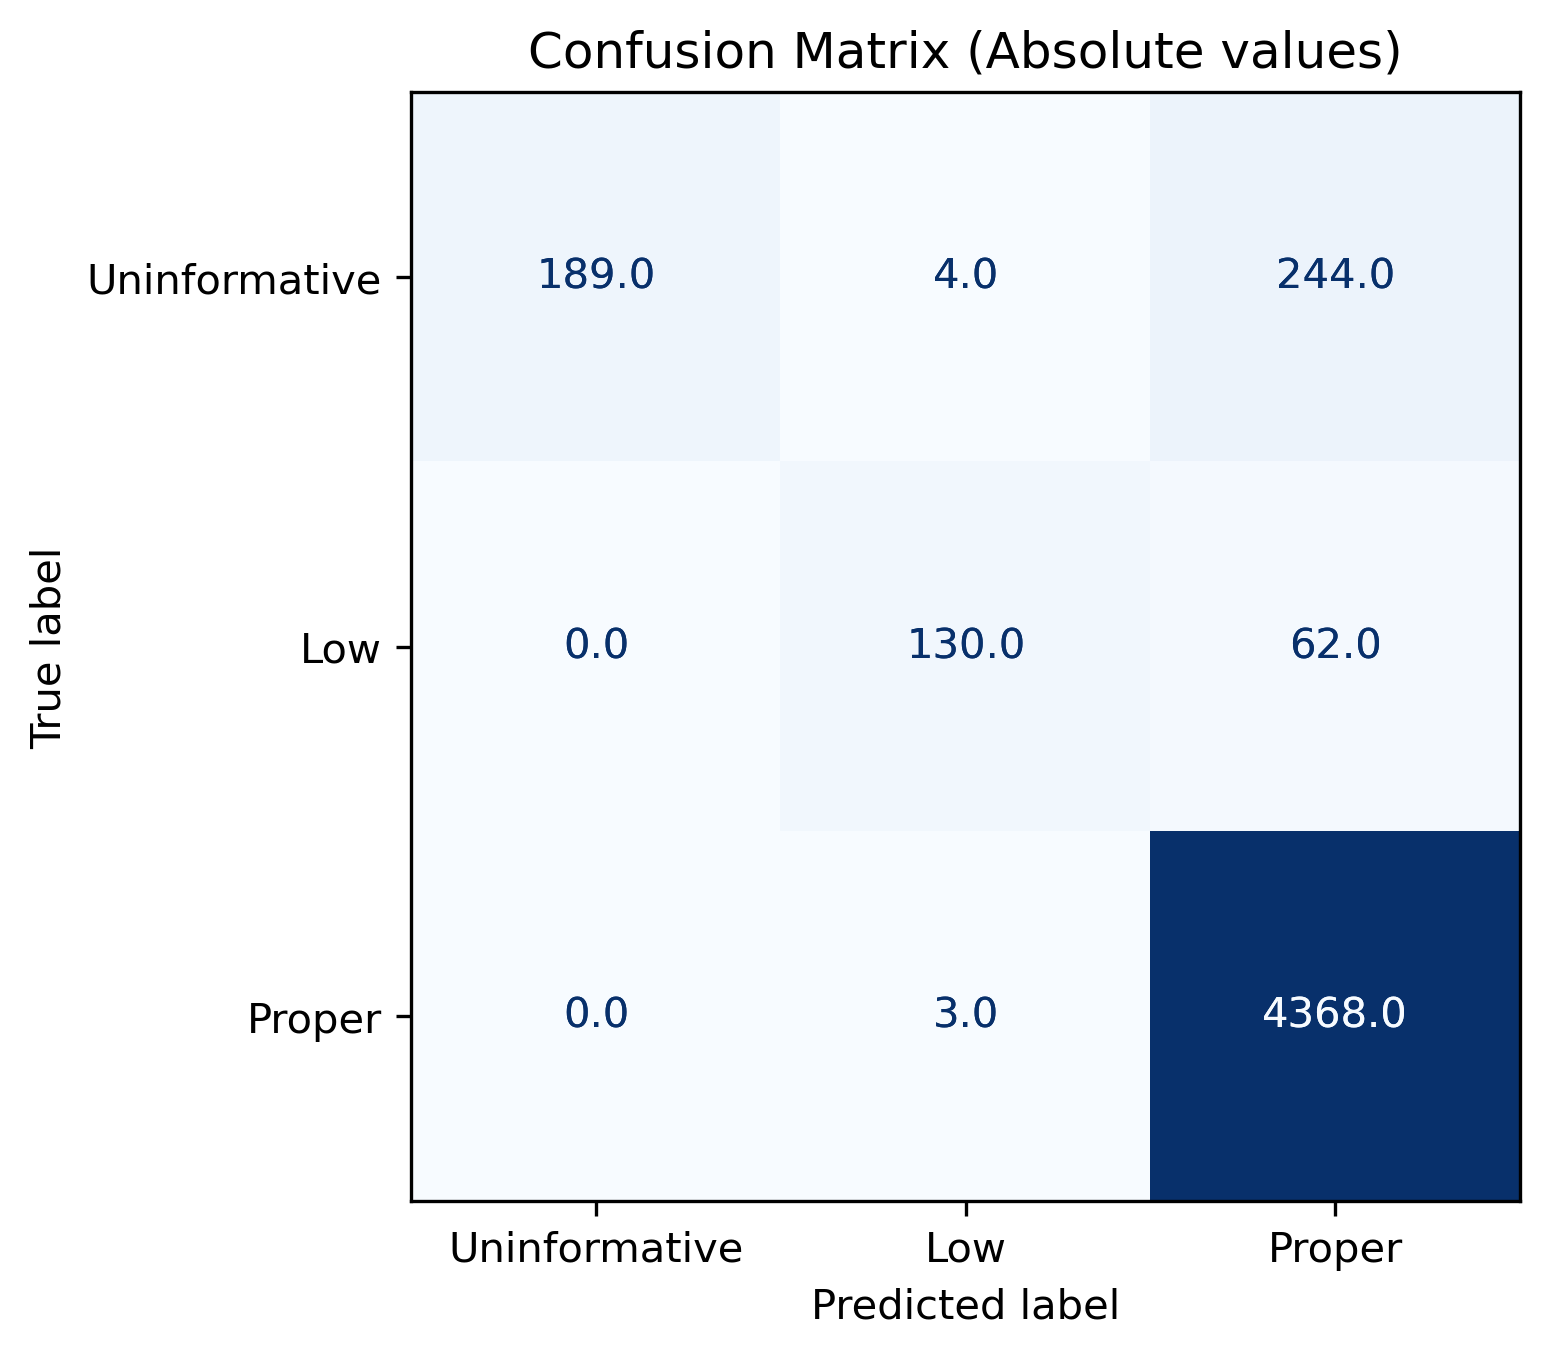
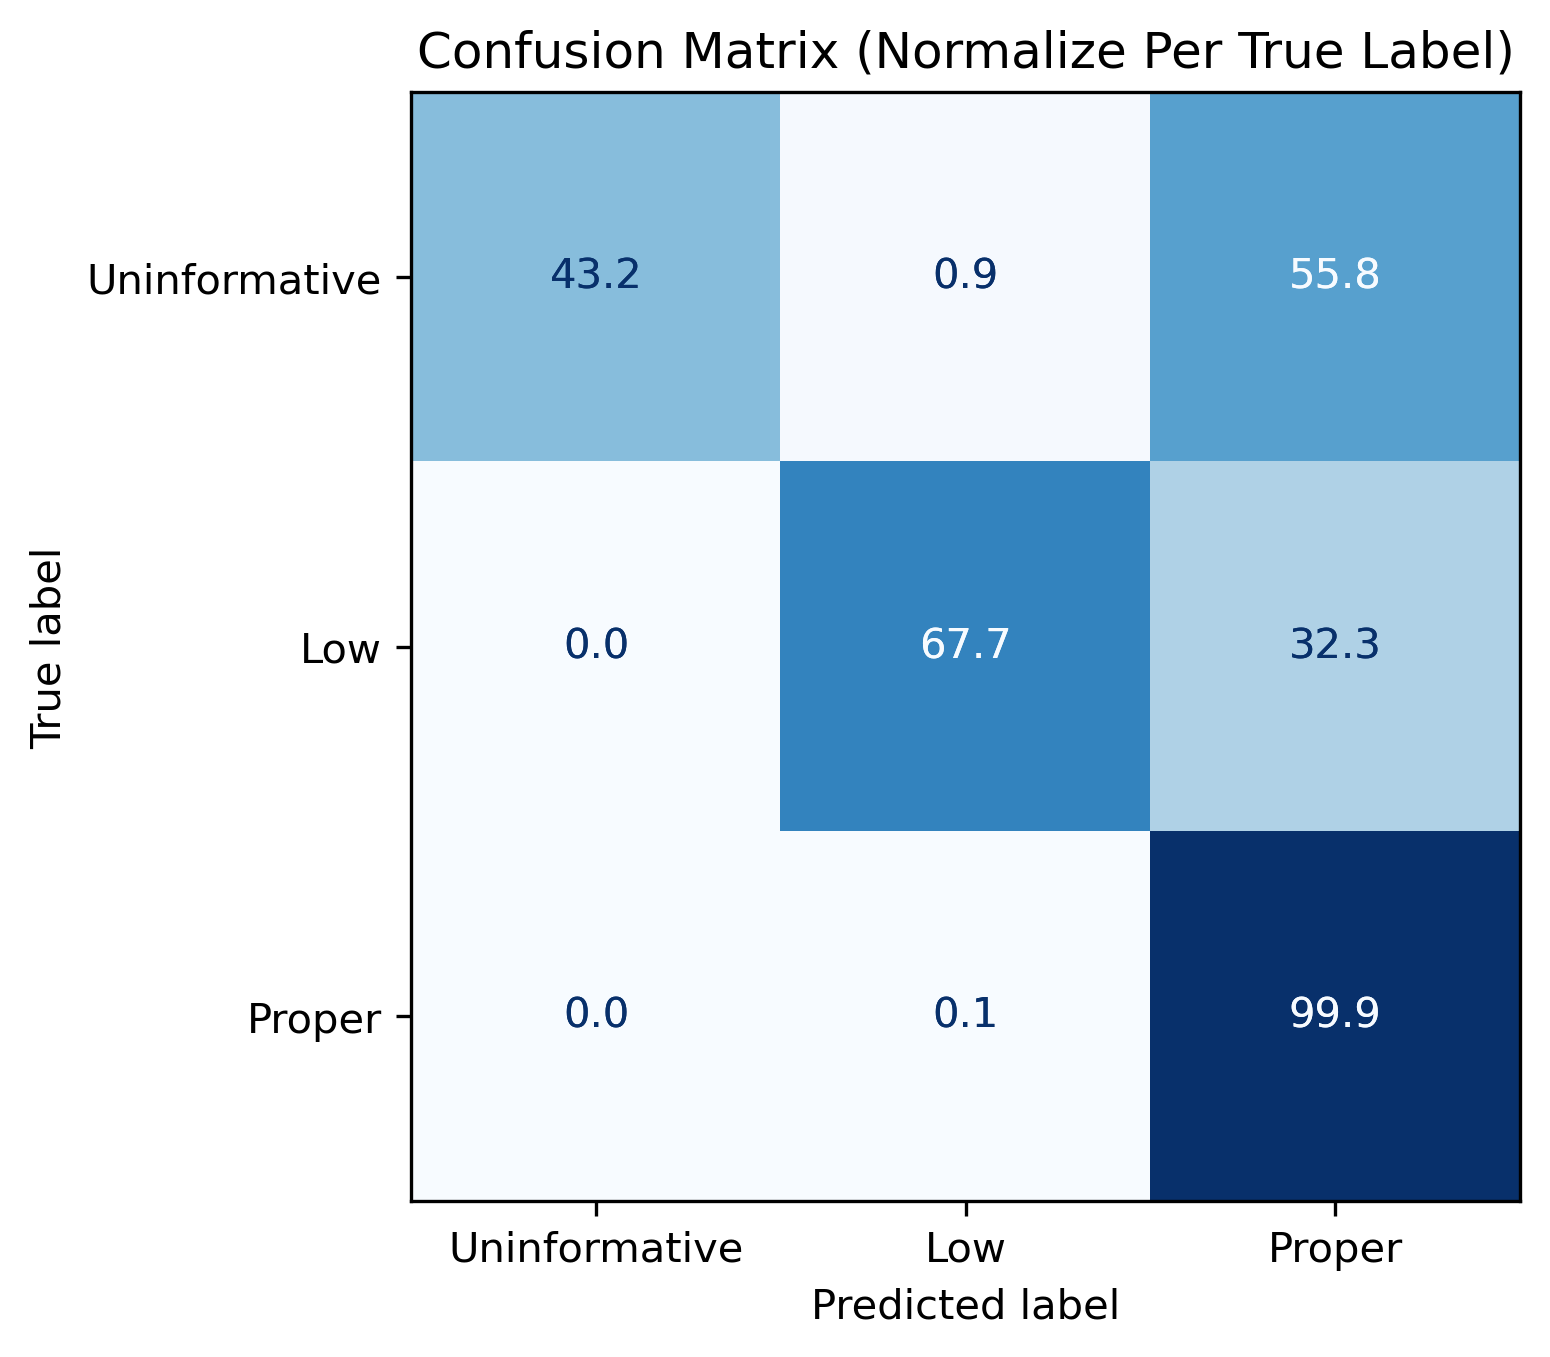

In [4]:
# regex model requrie no traning, so we can just predict on the eval set
# evaluator = ModelEvaluator(regex_m_wrapper, dataloader.get_train())
evaluator = ModelEvaluator(regex_m, all)

regex_report = evaluator.generate_report()
regex_report.show_report()

In [7]:
# # Save report to disk
# regex_report.save_to_file("report_regex.rep")

regex_report.eval_df != regex_report.eval_df 

,protein_annotation,label
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
495,False,False
496,False,False
497,False,False
498,False,False


In [ ]:
from models.embedder_with_classification_head import EmbedderClassifier
from data_loader import AnnotationDataLoader
from model_evaluation import ModelEvalWrapper, ModelEvaluator, ModelEvalWrapperInterface
from models.embedder_with_classification_head.embedders import SentenceTransformerEmbedder
from models.embedder_with_classification_head.classification_heads import NeuralNetClassifier

from datetime import datetime
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier

import os
# --- Your defined search space ---
MLP_param_grid = {
    # MLP Param
    'hidden_layer_sizes': [(50,), (100, 50), (64, 32), (32,), (32, 16)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'max_iter': [500, 1000, 1500],
    "random_state": [42],

    # external params
    "train_with_sample_weights": [True, False],
    
    "embedder_name" : ["pritamdeka/S-PubMedBert-MS-MARCO",
        "NeuML/pubmedbert-base-embeddings",
        "pritamdeka/S-BioBert-snli-multinli-stsb",
        "all-MiniLM-L6-v2",
        "all-mpnet-base-v2",
        "sentence-transformers/all-MiniLM-L6-v2"
    ]

}

# --- Generate the configurations ---
configurations = list(ParameterGrid(MLP_param_grid))


REPORT_FOLDER = "reports"
if not os.path.exists(REPORT_FOLDER):
    os.makedirs(REPORT_FOLDER)


print(f"Total configurations to test: {len(configurations)}")

for i, config in enumerate(configurations):
    print(i)

    if i == 3:
        break
    
    print(config)

    info_str = f"EmbedderClassifier(AnnotationEmbedder, NeuralNetClassifier)|{str(config)}"

    train_with_sample_weights = config.pop("train_with_sample_weights")
    embedder_name = config.pop("embedder_name")
   
    embedder = SentenceTransformerEmbedder(embedder_name)    
    classifier = NeuralNetClassifier(train_with_sample_weights=train_with_sample_weights, **config)

    embedder_m = EmbedderClassifier(embedder, classifier)

    model_title = ""

    embedder_m.model_title = "Embedder"
    embedder_m.model_info = info_str

    dataloader = AnnotationDataLoader()
    embedder_m.train(dataloader.get_train())

    filename_base = datetime.now().strftime(r"%Y%m%d_%H%M%S_Emebdder")

    m = ModelEvaluator(embedder_m, dataloader.get_validation())
    c_report = m.generate_report()
    # c_report.show_report()

    report_path = os.path.join(REPORT_FOLDER, f"{filename_base}_{embedder_m.model_title}.rep")
    c_report.save_to_file(report_path)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3974401302.py, line 24)

In [1]:
# comapre reports 
from models.regex import RegexModel
from data_loader import AnnotationDataLoader
from model_evaluation import ModelEvalWrapper, ModelEvaluator, ModelEvalWrapperInterface, ModelReport, ReportsComparison
import os
import glob
import pickle
REPORT_FOLDER = "reports"

search_path = os.path.join(REPORT_FOLDER, "*.rep")
all_reports_paths = glob.glob(search_path)
reports = []
for f in all_reports_paths:
    reports.append(ModelReport.load_report(f))


report_compare = ReportsComparison(reports)


In [12]:
# comapre reports 
from models.regex import RegexModel
from data_loader import AnnotationDataLoader
from model_evaluation import ModelEvalWrapper, ModelEvaluator, ModelEvalWrapperInterface, ModelReport, ReportsComparison
import os
import glob
import pickle
REPORT_FOLDER = "reports"

search_path = os.path.join(REPORT_FOLDER, "*423.rep")
all_reports_paths = glob.glob(search_path)[0]
p = ModelReport.load_report(all_reports_paths)

In [19]:
import pandas as pd
all_misclassified = []
for r in report_compare._reports:
    all_misclassified.extend(list(r.show_misclassified_samples()["protein_annotation"]))
mc = pd.DataFrame(all_misclassified)
mc.value_counts()

0                                                          
Cell wall protein containing Ig-like domains (Group2 and 3)    989
Putative mobile element protein                                971
Uncharacterized protein YjbI, contains pentapeptide repeats    968
Aste57867_24821 protein                                        961
GH73                                                           960
                                                              ... 
Phage terminase small                                            1
DNA replication factor                                           1
Arac-type arabinose-binding/dimerisation domain                  1
Arm-DNA-bind_2 domain-containing protein                         1
CD200 receptor 1 like                                            1
Name: count, Length: 572, dtype: int64

In [7]:
from models.embedder_with_classification_head import EmbedderClassifier
from data_loader import AnnotationDataLoader
from model_evaluation import ModelEvalWrapper, ModelEvaluator, ModelEvalWrapperInterface
from models.embedder_with_classification_head.embedders import SentenceTransformerEmbedder
from models.embedder_with_classification_head.classification_heads import NeuralNetClassifier,GenericSklearnCalssifier

from datetime import datetime


In [ ]:

# model_kwargs = {
#     "hidden_layer_sizes":(64, 32),
#     "activation":'relu',
#     "solver":'adam',        # use Adam optimizer
#     "learning_rate_init":0.001,
#     "max_iter":500,
#     "random_state":42
# }


# embedder = SentenceTransformerEmbedder(r"NeuML/pubmedbert-base-embeddings")
# classifier = NeuralNetClassifier(train_with_sample_weights=False, **model_kwargs)
# embedder_m = EmbedderClassifier(embedder, classifier)

# embedder_m.model_title = "Embedder"
# embedder_m.model_info = "Embedder"

# dataloader = AnnotationDataLoader()
# embedder_m.train(dataloader.get_train())





In [1]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct, Matern
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from data_loader import AnnotationDataLoader
from models.embedder_with_classification_head import EmbedderClassifier
from data_loader import AnnotationDataLoader
from model_evaluation import ModelEvalWrapper, ModelEvaluator, ModelEvalWrapperInterface
from models.embedder_with_classification_head.embedders import SentenceTransformerEmbedder
from models.embedder_with_classification_head.classification_heads import NeuralNetClassifier

from datetime import datetime
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier


from sklearn.model_selection import RandomizedSearchCV

## search space 
all_search_space = {
        KNeighborsClassifier: {
        "n_neighbors" : [3, 5, 10],
        "weights" : ["uniform", "distance"]
        },

        SVC: {
            "C" : [0.1, 1.0, 100],
            "kernel": ["rbf", "linear", "poly"],
            "degree": [2, 3, 4],
            "gamma": ["scale", "auto", 0.0001, 0.01],
            "random_state": [42]
        },

        GaussianProcessClassifier: {
        "kernel": [(1.0 * RBF(1.0), ),
                RBF(length_scale=1.0), 
                ConstantKernel(1.0) * RBF(length_scale=1.0),
                Matern(length_scale=1.0, nu=1.5),
                DotProduct()]
        },

        DecisionTreeClassifier: {
            "criterion": ["gini", "log_loss", "entropy"],
            "max_depth": [2, 5, 10, None],
            "random_state": [42]
        },

        RandomForestClassifier: {
            "max_depth":[5,10, None], 
            "n_estimators": [10, 100, 500, 1000], 
            "max_features": ["sqrt", "log2", None], 
            "random_state": [42],
            "class_weight": ["balanced", "balanced_subsample"]
        },

        AdaBoostClassifier : {
                "random_state":[42],
                "n_estimators": [50, 100, 200],
                "learning_rate": [0.01, 0.1]
        },

        MLPClassifier :{
                'hidden_layer_sizes': [(50,), (100, 50), (64, 32), (32,), (32, 16)],
                'activation': ['tanh', 'relu'],
                'solver': ['adam', 'sgd'],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate_init': [0.0001, 0.001, 0.01],
                'max_iter': [500, 1000, 1500],
                "random_state": [42],
                "early_stopping": [False, True]

        }
}


In [2]:
emebbder_space = ["pritamdeka/S-PubMedBert-MS-MARCO",
                    "NeuML/pubmedbert-base-embeddings",
                    "pritamdeka/S-BioBert-snli-multinli-stsb",
                    "all-MiniLM-L6-v2",
                    "all-mpnet-base-v2",
                    "sentence-transformers/all-MiniLM-L6-v2",
                    "kamalkraj/BioSimCSE-BioLinkBERT-BASE",
                    "potsu-potsu/bge-base-biomedical-matryoshka-v3",
                    "LiquidAI/LFM2-ColBERT-350M"
                    ]

## add it to the config 
emebbder_key = "emebbder__name"
for k in all_search_space.keys():
    all_search_space[k][emebbder_key] = emebbder_space

,protein_annotation,label
1,ARAD1C36740p,0
2,Abasic site processing protein YMR114C,2
3,Amino acid dehydrogenase,2
4,"Transcription regulator HTH, LysR",2
5,LytTR family transcriptional regulator,2
6,Cell wall-associated hydrolases,2
7,Recombination protein U,2
8,Snf2 family helicase-like protein,2
9,GD15429,0


In [14]:
import random

from models.embedder_with_classification_head import EmbedderClassifier
from data_loader import AnnotationDataLoader
from model_evaluation import ModelEvalWrapper, ModelEvaluator, ModelEvalWrapperInterface
from models.embedder_with_classification_head.embedders import SentenceTransformerEmbedder
from models.embedder_with_classification_head.classification_heads import GenericSklearnCalssifier
from sklearn.model_selection import RandomizedSearchCV, ParameterSampler

from datetime import datetime
from sklearn.model_selection import ParameterGrid
import os
from sklearn.model_selection import ParameterGrid, RandomizedSearchCV, ParameterSampler

configs_per_cls = 250

all_configs_per_cls = {}
REPORT_FOLDER = "reports"

if not os.path.exists(REPORT_FOLDER):
    os.makedirs(REPORT_FOLDER)


for cls, search_space_cls in all_search_space.items():

    sampler = ParameterSampler(
        param_distributions=search_space_cls,
        n_iter=configs_per_cls
        )
    all_configs_per_cls[cls] = list(sampler)


dataloader = AnnotationDataLoader()

i = 0
for cls, configs in all_configs_per_cls.items():
    for config in configs: 
        i = i + 1
        try:
            config_str = str(config)
            embedder_name = config.pop(emebbder_key)
            
            # create models
            embedder = SentenceTransformerEmbedder(embedder_name)
            classifier = GenericSklearnCalssifier(cls, model_kwargs=config)
            embedder_m = EmbedderClassifier(embedder, classifier)

            # setup title and info
            escaped_name = embedder_name.replace('/', '_').replace('\\', '_')
            model_title = f"{escaped_name} with MLP config {i}"
            info_str = f"EmbedderClassifier({embedder.__class__.__name__}, {cls.__name__}) || {config_str}"
            embedder_m.model_title = model_title
            embedder_m.model_info = info_str

            embedder_m.train(dataloader.get_train())

            # eval the model
            filename_base = datetime.now().strftime(r"%Y%m%d_%H%M%S_Emebdder")
            m = ModelEvaluator(embedder_m, dataloader.get_validation())
            c_report = m.generate_report()
            report_path = os.path.join(REPORT_FOLDER, f"{filename_base}_{embedder_m.model_title}.rep")
            c_report.save_to_file(report_path)
        except Exception as e:
            print(e)
                    


c:\Users\Elon\anaconda3\envs\main\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 54 is smaller than n_iter=250. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Elon\anaconda3\envs\main\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 45 is smaller than n_iter=250. Running 45 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Elon\anaconda3\envs\main\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 108 is smaller than n_iter=250. Running 108 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


reports\20251107_115802_Emebdder_pritamdeka_S-PubMedBert-MS-MARCO with MLP config 1.rep


KeyboardInterrupt: 

In [ ]:
embedder_m


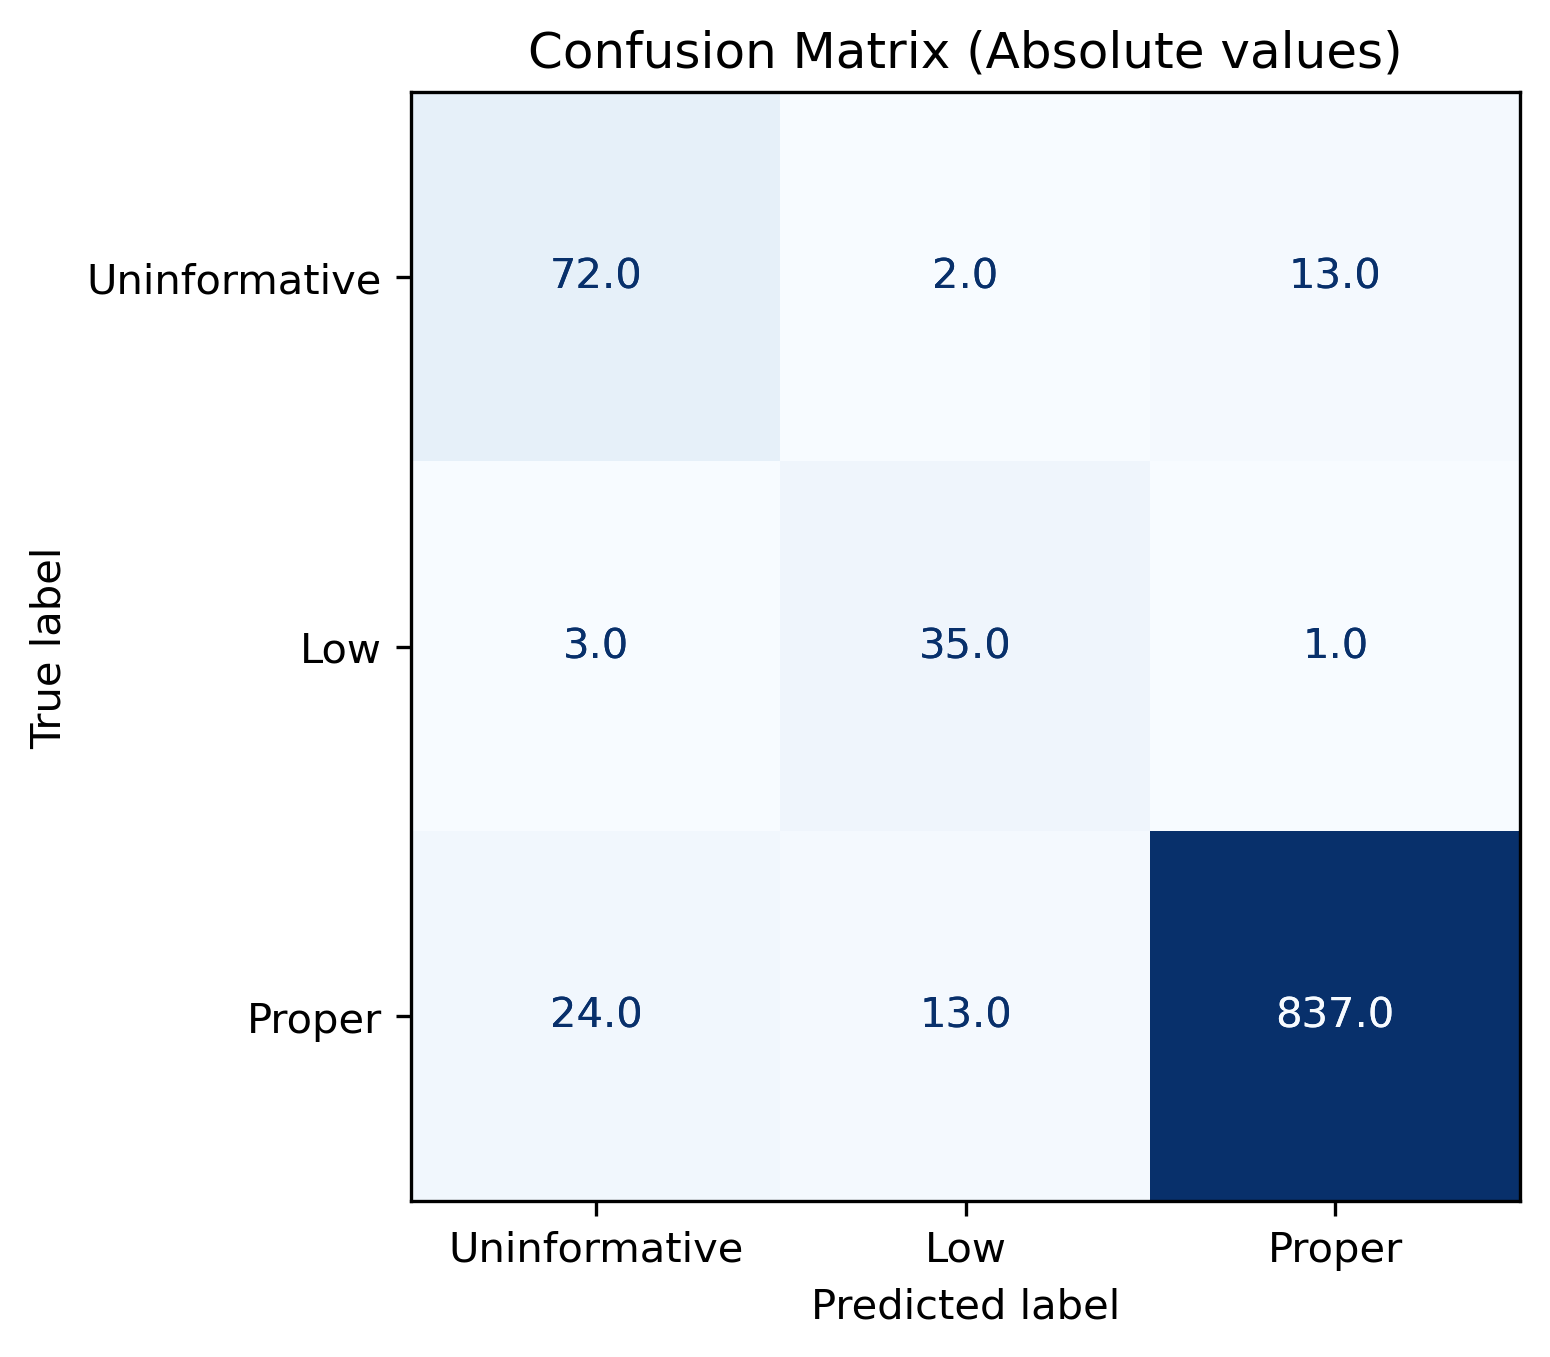
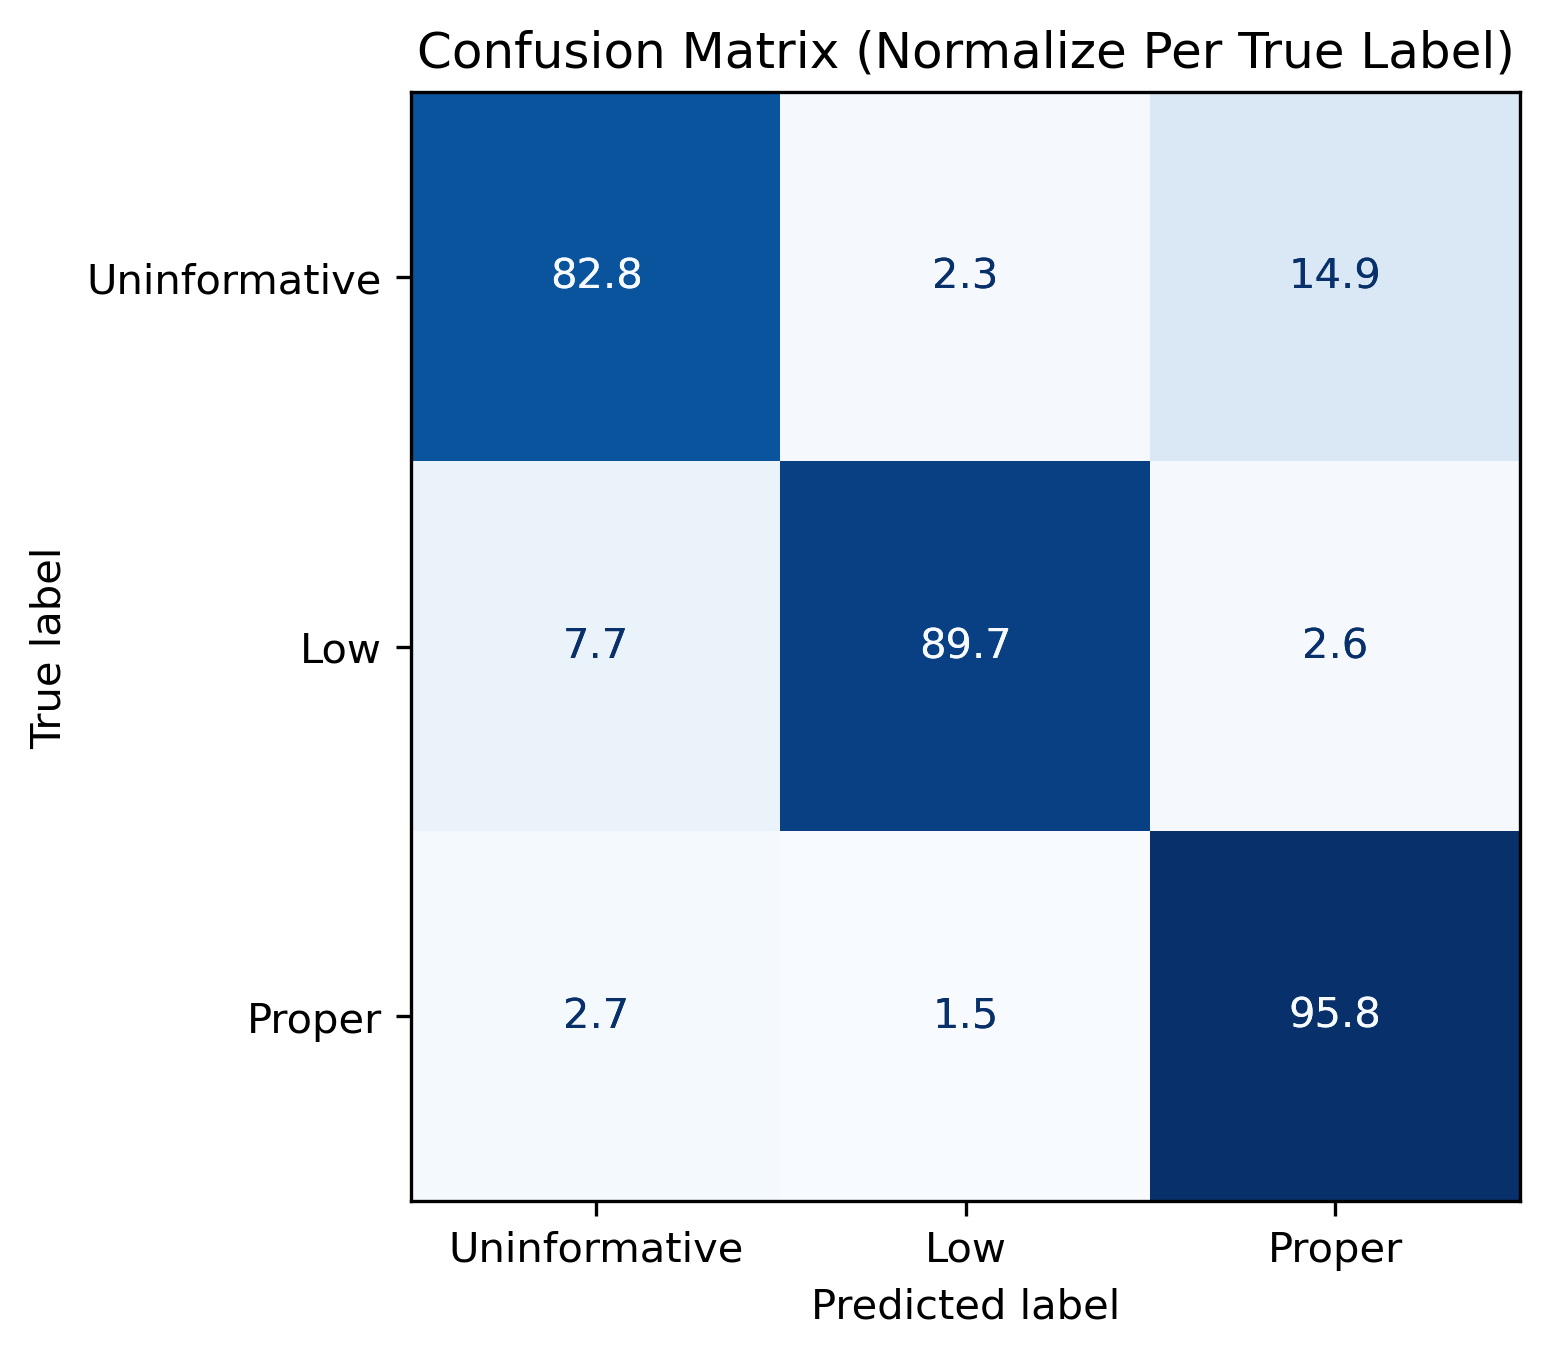

In [3]:
m = ModelEvaluator(embedder_m, dataloader.get_validation())
c_report = m.generate_report()
c_report.show_report()


In [ ]:

# from sklearn.neural_network import MLPClassifier

        
# embedder_m._classification_head =  MLPClassifier(hidden_layer_sizes=(64, 32),
#     activation='relu',
#     solver='adam',        # use Adam optimizer
#     learning_rate_init=0.001,
#     max_iter=500,
#     random_state=42)

# embedder_m.train(dataloader.get_train())

In [ ]:
m = ModelEvaluator(embedder_m, dataloader.get_validation())
c_report = m.generate_report()
c_report.show_report()

In [6]:
c_report.show_misclassified_samples(true_label_to_filter=2)

,protein_annotation,true_label,predicted_label
34,Putative bacteriophage regulatory protein,2,0
64,Uncharacterized protein with gpF-like domain,2,0
65,Cocosin 1,2,0
85,Rnr22p,2,0
130,Bacteriophage resistance protein,2,0
131,Aste57867_24821 protein,2,0
190,Bro-N domain-containing protein 019R,2,0
232,WD40 repeat domain protein,2,1
375,Phage eae protein,2,0
376,Bacteriophage/transposase fusion protein,2,0


In [ ]:
# len(embedder_m._embed(["asd"][0]))

384

In [ ]:
# c_report.save_to_file("embbeder_report")